In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import clean_data

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]

def clean_df(df):
    df = clean_data.add_epoch_data(df)
    df = clean_data.normalize_all_columns(df)
    return df

def clean_all(train_df, test_df):
    train_df = clean_df(train_df)
    test_df = clean_df(test_df)
    return train_df,test_df

def load_all():
    train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' ) # Time: 25.7s
    #test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test.pkl' ) # Time: 5
    return train_df #, test_df

train_df = load_all()
#train_df,test_df = clean_all(train_df, test_df)

|NORAD|Count of TLEs|
|-|-|
|3506|     19285|
|10839|    19557|
|3938|     19724|
|8142|     20576|
|14631|    21571|

In [2]:
train_model_df = train_df[['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'EPOCH']]
train_model_df.describe()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
count,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07
mean,1.459784e-03,8.419035e+01,1.801053e+02,2.158388e-02,1.784617e+02,1.812822e+02,1.375314e+01
std,5.064926e-02,1.819075e+01,1.038900e+02,4.841379e-02,1.038260e+02,1.055550e+02,2.212779e+00
min,-2.618100e+01,9.900000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.981056e-01
25%,1.000000e-04,7.099900e+01,9.012995e+01,4.108700e-03,8.862640e+01,8.851405e+01,1.340196e+01
50%,2.594200e-04,8.913500e+01,1.801751e+02,9.078400e-03,1.769953e+02,1.823633e+02,1.398493e+01
75%,8.218200e-04,9.902480e+01,2.702199e+02,1.980150e-02,2.682896e+02,2.741587e+02,1.436245e+01
max,3.014907e+02,1.446946e+02,3.600000e+02,9.301648e-01,3.600000e+02,9.999999e+02,1.425793e+04


In [3]:
import numpy as np

(train_model_df['ECCENTRICITY']).describe()

count    5.489969e+07
mean     2.158388e-02
std      4.841379e-02
min      0.000000e+00
25%      4.108700e-03
50%      9.078400e-03
75%      1.980150e-02
max      9.301648e-01
Name: ECCENTRICITY, dtype: float64

In [4]:
train_df = train_df[train_df['NORAD_CAT_ID'] == 14631].reset_index(drop=True)
train_df = clean_df(train_df)
train_model_df = train_df[model_cols]
idx_map = clean_data.create_index_map(train_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.18it/s]


In [7]:
split = 0.8
train_idx_map = idx_map[:int(len(idx_map)*split)]
test_idx_map = idx_map[int(len(idx_map)*split):]

In [35]:
import train

model = train.create_model(model_cols=model_cols,
                           layer1=300, relu1=True, #drop1=0.5,
                           layer2=300, relu2=True, #drop2=0.5,
                           layer3=200, relu3=True, #drop3=0.5,
                           layer4=200, relu4=True, #drop3=0.5,
                           layer5=100, relu5=True, #drop3=0.5,
                           layer6=100, relu6=True, #drop3=0.5,
                          )
model

NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=7, bias=True)
  )
)

In [36]:
%%time
device='cpu'
trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=2000,
                                               print_itr=8, numEpochs=20, model_cols=model_cols,
                                               learningRate=0.0001, device=device, num_workers=5,
                                               loss='L2', model=model)

>>> Loading dataset
>>> Beginning training!
Epoch [1/20], Batch [8/8], Loss: 0.43703073263168335, Time: 2s
Epoch [2/20], Batch [8/8], Loss: 0.43172338604927063, Time: 1s
Epoch [3/20], Batch [8/8], Loss: 0.3946259617805481, Time: 1s
Epoch [4/20], Batch [8/8], Loss: 0.357226699590683, Time: 1s
Epoch [5/20], Batch [8/8], Loss: 0.2931727170944214, Time: 1s
Epoch [6/20], Batch [8/8], Loss: 0.20329387485980988, Time: 1s
Epoch [7/20], Batch [8/8], Loss: 0.08915767818689346, Time: 1s
Epoch [8/20], Batch [8/8], Loss: 0.05641128867864609, Time: 1s
Epoch [9/20], Batch [8/8], Loss: 0.0413956418633461, Time: 1s
Epoch [10/20], Batch [8/8], Loss: 0.055653344839811325, Time: 1s
Epoch [11/20], Batch [8/8], Loss: 0.03984275087714195, Time: 1s
Epoch [12/20], Batch [8/8], Loss: 0.039641302078962326, Time: 1s
Epoch [13/20], Batch [8/8], Loss: 0.039383452385663986, Time: 1s
Epoch [14/20], Batch [8/8], Loss: 0.03928213566541672, Time: 1s
Epoch [15/20], Batch [8/8], Loss: 0.03935055434703827, Time: 1s
Epoch [

In [37]:
X_train,y_train = clean_data.build_xy(train_model_df,train_idx_map)  # create input/label pair
X_test,y_test = clean_data.build_xy(train_model_df,test_idx_map)  # create input/label pair
y_train_pred = train.predict(trained_model, X_test, device=device) # get predictions for each train
y_test_pred = train.predict(trained_model, X_test, device=device) # get predictions for each test
y_train_pred_df = pd.DataFrame(y_train_pred, columns=train_model_df.columns[:-2])  # put results into a dataframe
y_test_pred_df = pd.DataFrame(y_test_pred, columns=train_model_df.columns[:-2])  # put results into a dataframe

    Test set MAE (L1) loss: 0.12926783594947402
    Test set MSE (L2) loss: 0.04040143757652119


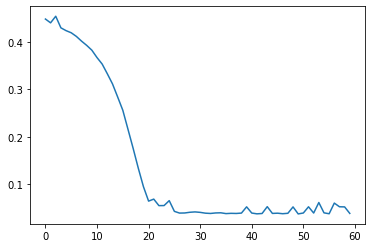

In [38]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_test_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_test_pred_df)}')

plt.plot([float(l['loss']) for l in loss_output])

In [39]:
print("Train - Ground Truth:")
display(clean_data.normalize_all_columns(y_train.head().copy(), reverse=True))  # see ground truths
print("Train - Prediction:")
display(clean_data.normalize_all_columns(y_train_pred_df.head().copy(), reverse=True))  # See predictions

Train - Ground Truth:


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000026,97.7017,28.9327,0.000934,122.8154,237.3988,15.335730
1,0.000072,97.8301,335.6019,0.001022,112.6469,247.5852,15.303951
2,0.000023,97.7014,57.4855,0.000888,41.3231,318.8681,15.336172
3,0.000482,97.8829,358.8722,0.001762,47.3249,312.9345,15.008688
4,0.000004,97.7240,252.4612,0.001419,47.8965,312.3428,15.126075


Train - Prediction:


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000178,89.174011,170.906235,-0.000674,157.735916,169.521225,15.056093
1,0.000223,87.241257,168.153168,-0.001056,154.305862,165.049469,15.030491
2,0.000135,99.166473,183.849075,0.001667,173.425018,190.993622,15.181568
3,0.000140,93.764084,177.005615,0.000153,164.452667,178.922989,15.112304
4,0.000107,98.300484,182.921616,0.001168,171.939514,189.178223,15.171638


In [40]:
print("Test - Ground Truth:")
display(clean_data.normalize_all_columns(y_test.head().copy(), reverse=True))  # see ground truths
print("Test - Prediction:")
display(clean_data.normalize_all_columns(y_pred_df.head().copy(), reverse=True))  # See predictions

Test - Ground Truth:


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000082,97.6910,140.1478,0.003322,50.7256,309.6934,14.824075
1,0.000141,97.8194,144.3225,0.000997,41.7163,318.4835,15.291636
2,0.000228,97.8106,14.8127,0.002319,229.8543,130.0447,14.956376
3,0.000018,97.7605,84.5032,0.000721,212.6700,147.4095,15.325564
4,0.000143,97.6938,164.5709,0.001173,17.8804,342.2766,15.182641


Test - Prediction:


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000163,92.234970,168.184357,0.000185,165.831818,175.274353,15.066766
1,0.000274,87.411316,159.385895,0.002995,158.152054,168.056061,15.003743
2,-0.000122,103.320694,189.371429,0.000630,179.990616,192.972366,15.221066
3,0.000335,88.142273,160.119431,0.002236,159.142105,168.378891,15.010106
4,0.000204,94.913864,170.271835,0.000339,169.128891,178.590485,15.090136
